# Planet: Understanding the Amazon deforestation from Space challenge

Add the files to the python path according to the project structure

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

## Import required modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import data_helper
from keras_helper import AmazonKerasClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Inspect image labels
Lets take a look at what the training set looks like

In [3]:
train_jpeg_dir, test_jpeg_dir, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'clear', 'conventional_mine', 'water', 'primary', 'agriculture', 'artisinal_mine', 'blooming', 'cultivation', 'bare_ground', 'selective_logging', 'blow_down', 'partly_cloudy', 'slash_burn', 'road', 'cloudy', 'habitation', 'haze'}


### Repartition of each labels

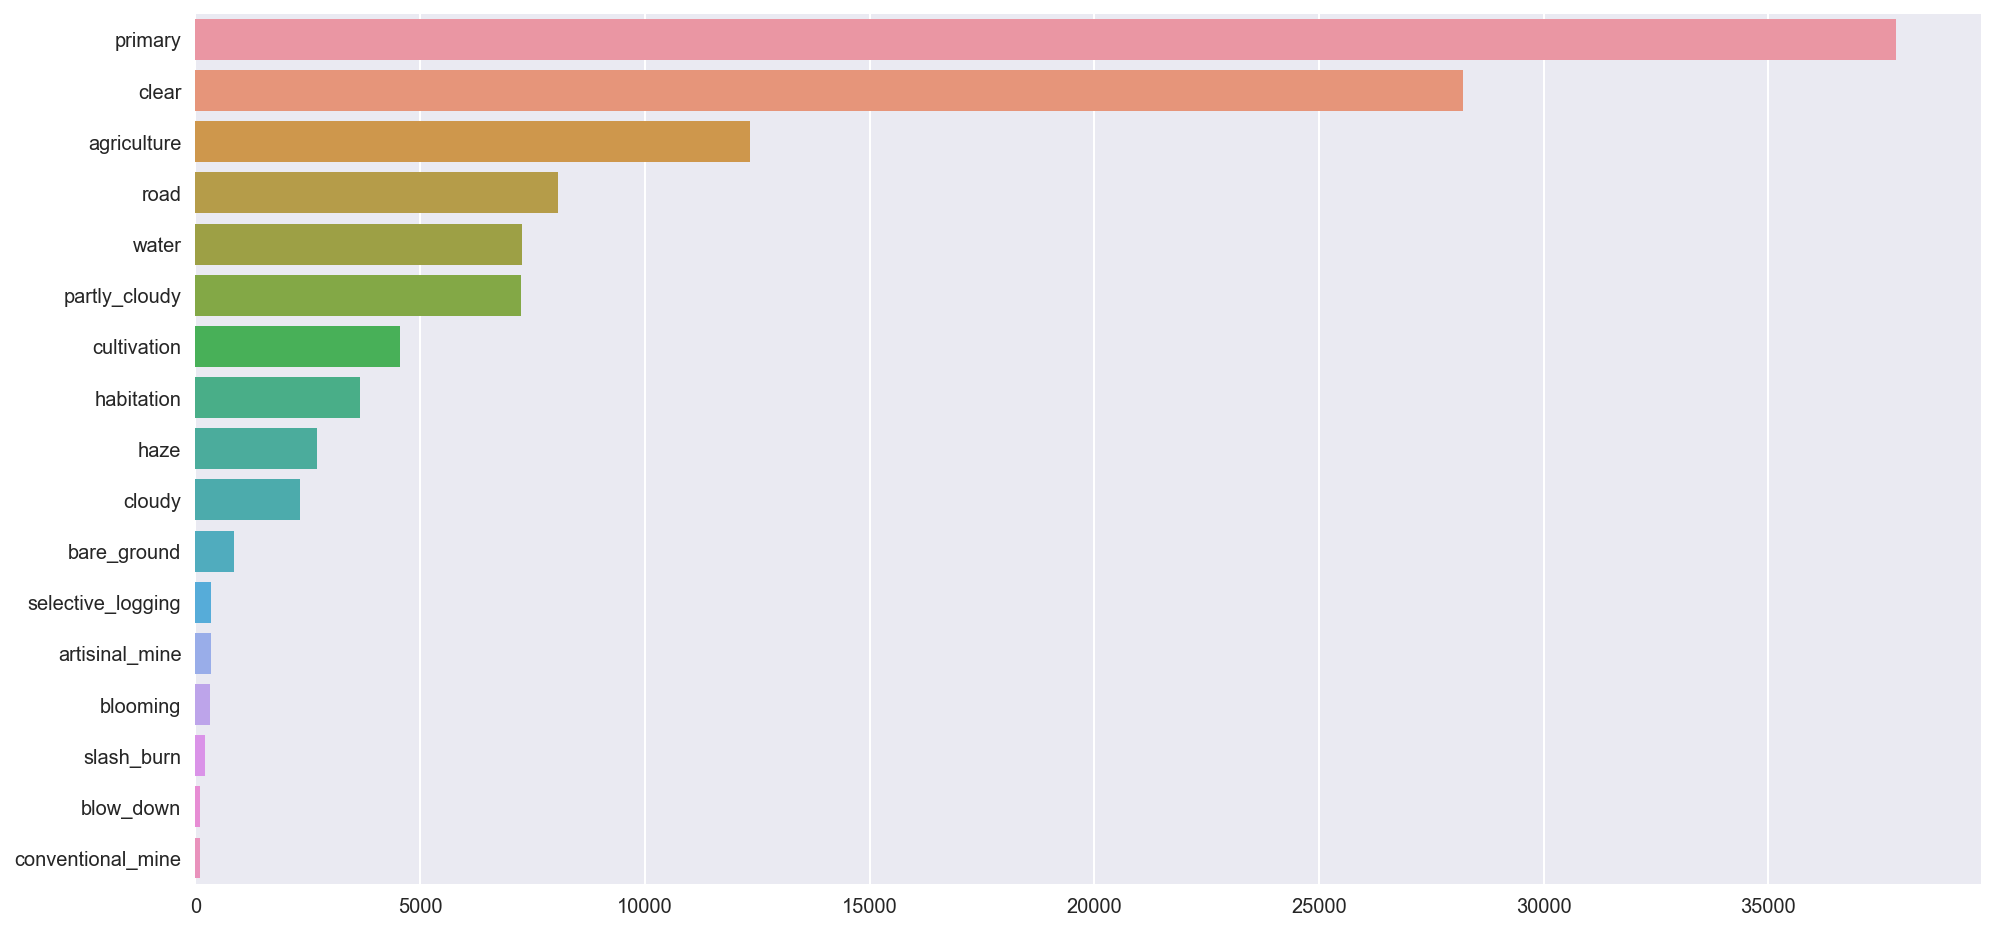

In [5]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Finally lets visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

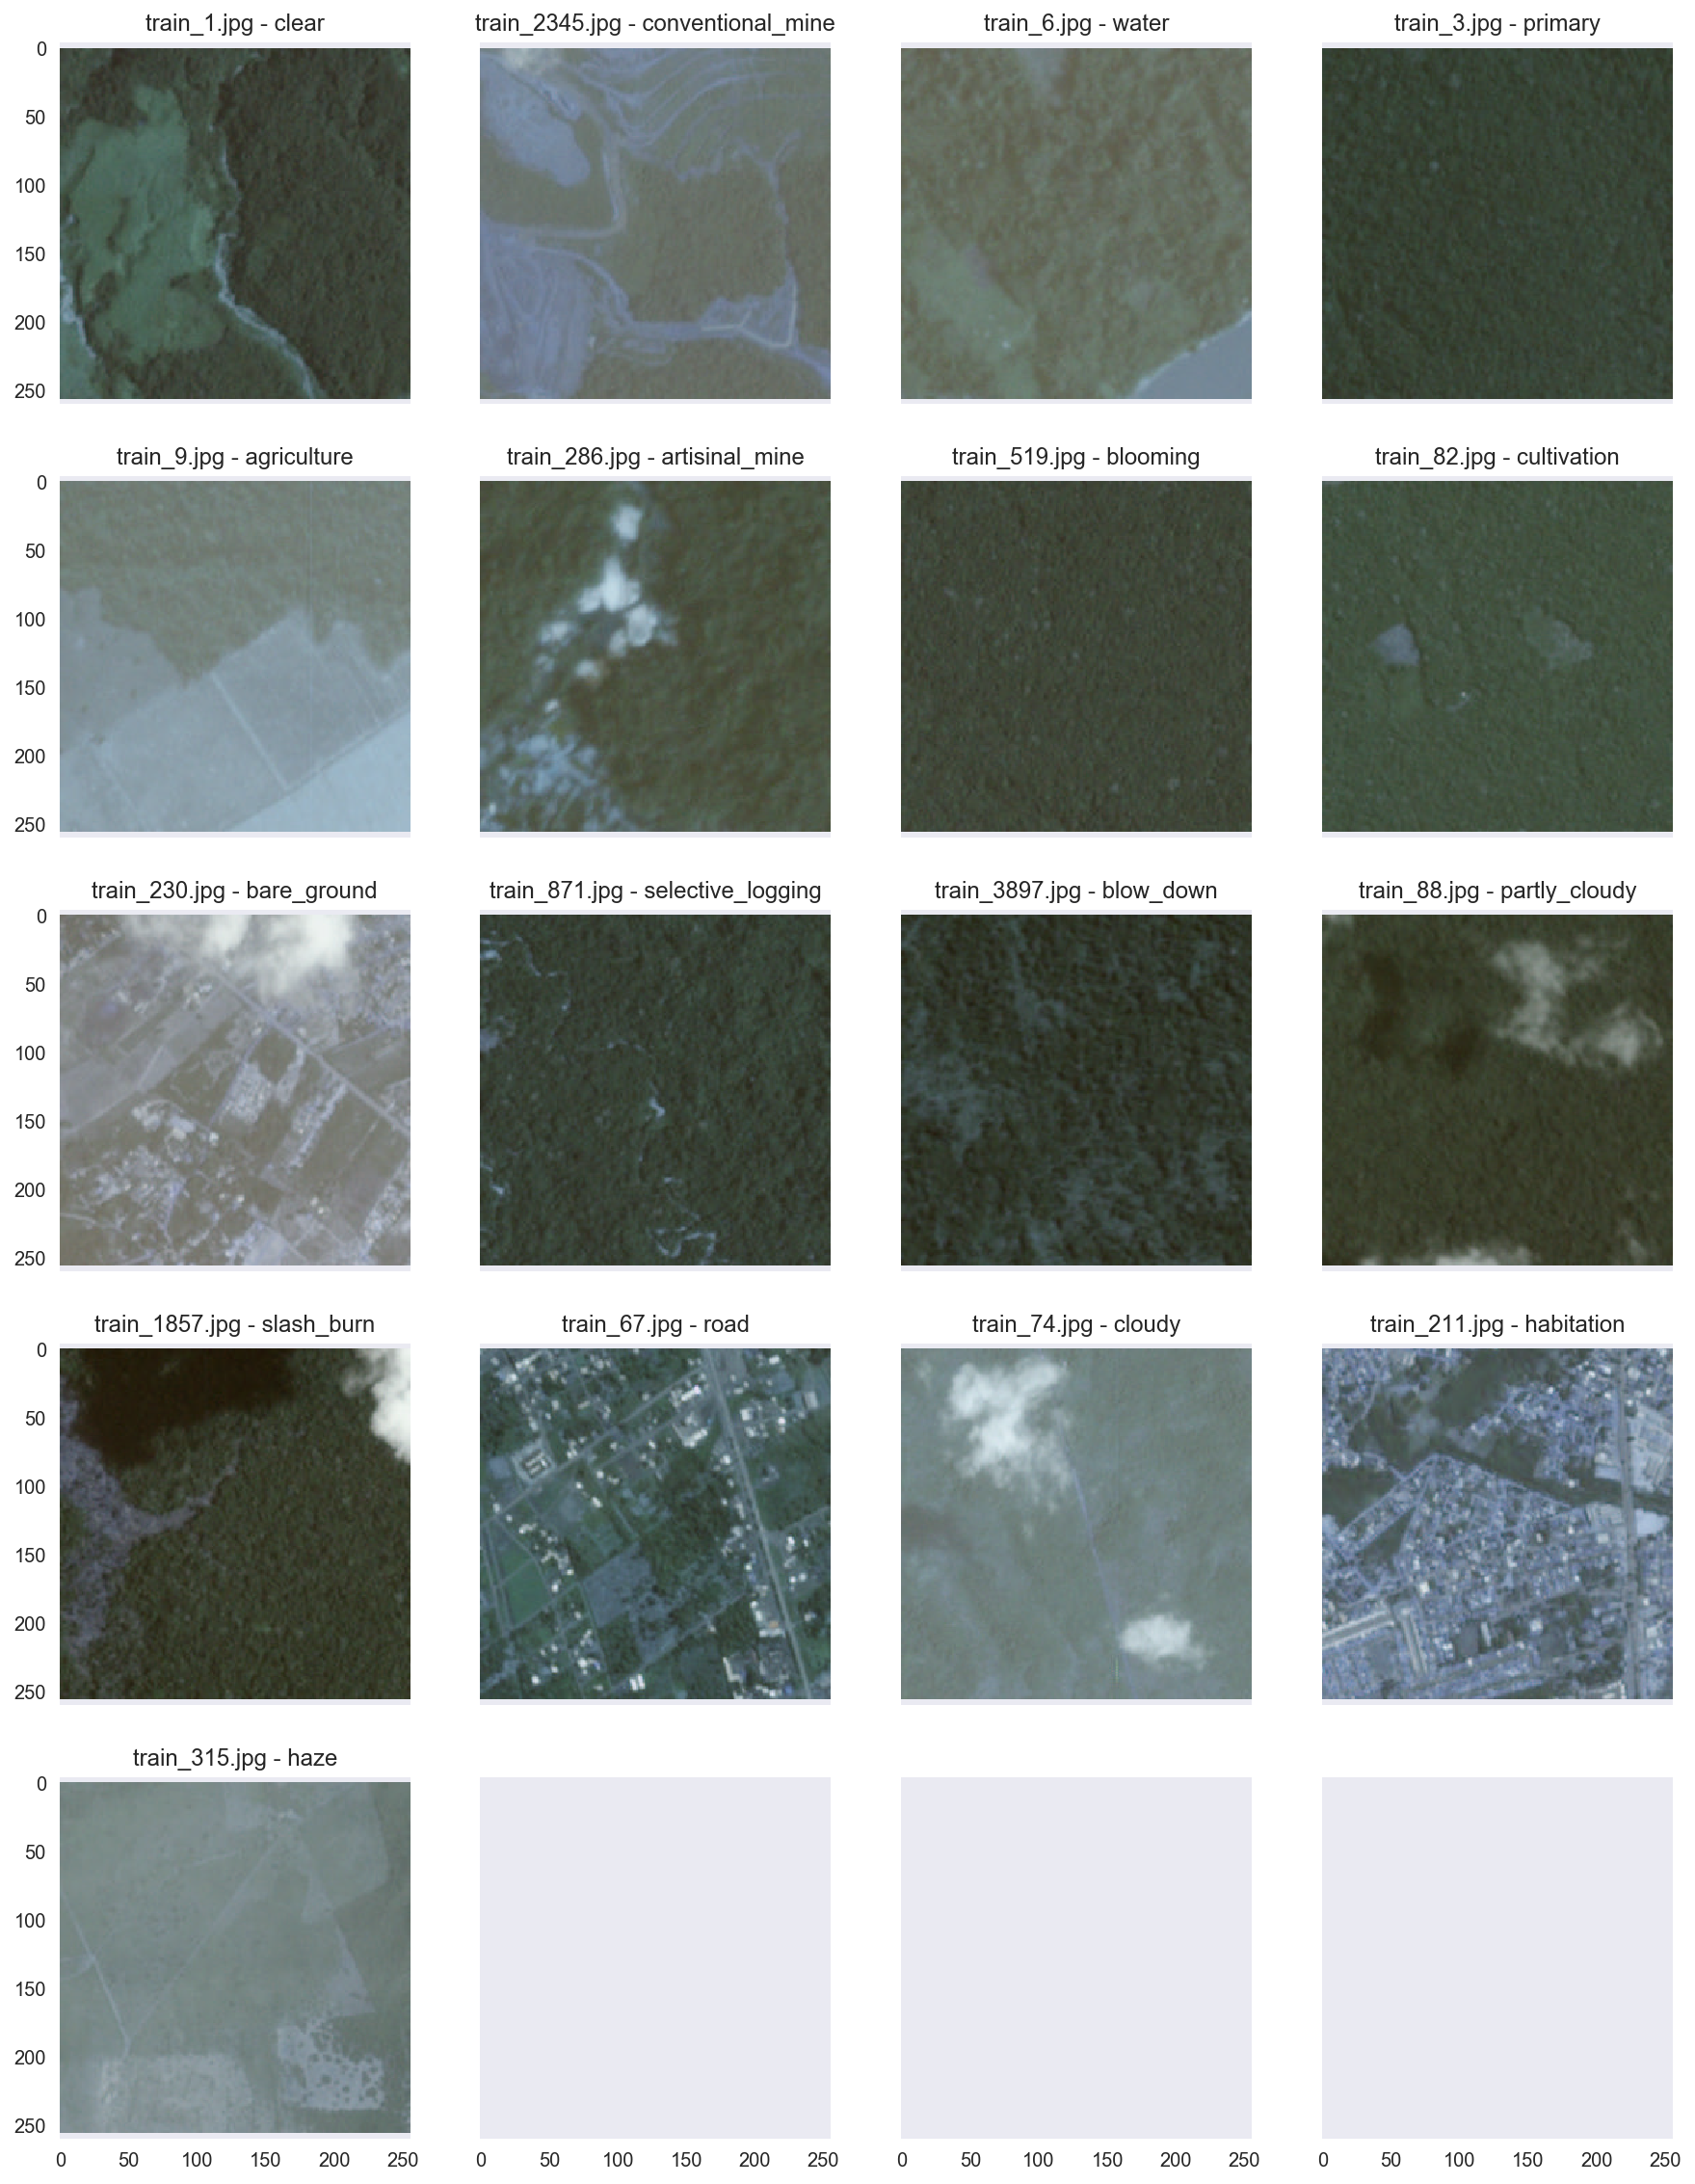

In [6]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = cv2.imread(train_jpeg_dir + '/' + image_name, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Data preprocessing
Preprocess the data in order to fit it into the Keras model

In [7]:
x_train, x_test, y_train, y_map = data_helper.preprocess_data(train_jpeg_dir, test_jpeg_dir, train_csv_file)

Transforming train data to matrices...


100%|██████████| 40479/40479 [00:30<00:00, 1347.77it/s]


Transforming test data to matrices...


100%|██████████| 40669/40669 [00:29<00:00, 1358.82it/s]

Done.


Lets take a look at our `y_map` and the shape of our train/test sets

In [11]:
print("x_train shape: {}".format(x_train.shape))
print("x_test  shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
y_map

x_train shape: (40479, 32, 32, 3)
x_test  shape: (40479, 32, 32, 3)
y_train shape: (40479, 17)


{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

## Create the neural network definition